## <font color='red'>FACTORIZATION MACHINES</font> 


In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pylab as plt
from scipy import sparse
from scipy.sparse import csr_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('movielens-fds'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

movielens-fds/training.csv
movielens-fds/test.csv
movielens-fds/sample_submission.csv


In [16]:
def evaluate(predict_f,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = np.array([predict_f(u,i) for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

## Divide the data in two sets: training and test
def assign_to_set(df,seed=3):
    np.random.seed(seed)
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.05)),
                                   replace=False)
    df['for_testing'] = False
    df.loc[sampled_ids, 'for_testing'] = True
    return df


In order to implement my code for FM I built a get_x() function: a function that takes as input (user_id, movie_id) and gives as output a sparse vector $X=(0,..,1,0,...,1,..) \in R^P$, where $P$ are the dimensions N_dummies, given by the one hot encode of the training data: the ones are in the positions $i$ and $j$, and $i$ maps the users and $j$ the movies. I.e. P=N_users + N_movies (I will add extra features in a second step). 

I also updated the evaluate function, that is always based on a RMSE metric.

In [17]:
def get_x(user_id, movie_id, dummie_idx_users, dummie_idx_movies, N_dummies):
    hot_user = dummie_idx_users[user_id] ; hot_movie = dummie_idx_movies[movie_id]
    row = np.array([0,0]) ; col = np.array([hot_user,hot_movie]) ; data = np.array([1, 1]) 
    x = csr_matrix((data, (row, col)), shape=(1, N_dummies))
    return x

def evaluate2(predict_f, data_test, users_index, movies_index, mean_rating, dummie_idx_users, dummie_idx_movies, N_dummies):
    
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = []
    
    for u,i in ids_to_estimate:
        if u not in users_index and i in movies_index:
            estimated.append(3)
        
        if u in users_index and i in movies_index:
            x = get_x(u,i,dummie_idx_users,dummie_idx_movies,N_dummies)
            estimated.append(predict_f(x))
            
        if i not in movies_index:
            estimated.append(mean_rating) # this is a new movie

    real = data_test.rating.values
    return compute_rmse(estimated, real)
    

In [18]:
df = pd.read_csv('./movielens-fds/training.csv')
df.head()

grouped    = df.groupby('user_id', group_keys=False).apply(assign_to_set)
df_train = df[grouped.for_testing == False]
df_val   = df[grouped.for_testing == True]

And here the model: is based on the logic we used in class for the Vanilla one and on the equations from the original paper "Factorization Machines - Steffen Rendle - Osaka University, 2010".

For the predict part I took advantage of the reformulation of the interaction part, that has only linear complexity $O(KN)$, where K is the dimension of the latent space, our parameter "num_components", and N of the vector $X$:

$$
\frac{1}{2} \sum_{f=1}^K [(\sum_{i=1}^N V_{i,f} x_i)^2 - \sum_{i=1}^N V_{i,f}^2 x_i^2)]
$$

The components of the gradient in the SGD are $\frac{\partial L}{\partial \theta} = \frac{\partial L}{\partial \hat y} \frac{\partial \hat y}{\partial \theta}$. 

Where: 

$\frac{\partial \hat y}{\partial \theta} = 1 ,\; \;$ if $\theta = w_0$ 

$\frac{\partial \hat y}{\partial \theta} = x_i,\; \;$ if $\theta = w_i$ 

$\frac{\partial \hat y}{\partial \theta} = x_i[\sum_1^N V_{j,f} x_j - V_{i,f} x_i],\; \;$ if $\theta = V_{i,f}$.   


In [90]:
import ast
V = np.array(pd.read_csv('V_simple_5.csv', header=None))
param = pd.read_csv('param_simple_5.csv')
w = np.array(ast.literal_eval(pd.read_csv('param_simple_5.csv')['w'][0]))
w0 = param['wo']

In [96]:
class RecSys_fm():
    """ Collaborative filtering using a custom sim(u,u'). """

    def __init__(self,df_train,df_val, V, w, w0, trained=False, num_components=10):
        """ Constructor """
        self.df_train = df_train
        self.df_val   = df_val
        self.trained = trained

        self.num_components = num_components
        self.N_samples    = len(self.df_train)
        self.users_index  = set(self.df_train.user_id)
        self.movies_index = set(self.df_train.movie_id)
        self.N_users      = len(self.users_index) 
        self.N_movies     = len(self.movies_index)
        self.N_dummies = self.N_users + self.N_movies 
        #Dictionaries where I store the corrispondence between user_id, movie_id and their position 
        #in a one-hot-encode matrix.
        self.dummie_idx_users  = dict(zip(self.users_index, range(self.N_users)))
        self.dummie_idx_movies = dict(zip(self.movies_index, range(self.N_users,self.N_users+self.N_movies)))
        
        if self.trained == True:
            self.w0 = w0
            self.w  = w
            self.V  = V
            self.mean_rating = self.df_train.rating.mean()
        
    def __sdg__(self):
        l = []
        for idx in self.training_indices:
            l.append(idx)
            if len(l)%10000 == 0: print('Wait {} idxs'.format(len(self.training_indices)-len(l)))
            y     = np.array(self.df_train.iloc[idx,3]) 
            user  = self.df_train.iloc[idx,:].user_id
            movie = self.df_train.iloc[idx,:].movie_id
            x     = get_x(user, movie, self.dummie_idx_users, self.dummie_idx_movies, self.N_dummies)
            
            prediction = self.predict(x)
            #the base derivative to evaluate each gradient
            loss_derivative = 2*(prediction-y)
            #Update w0
            grad_w0 = loss_derivative
            self.w0 = self.w0 - self.learn_rate * (grad_w0 + 2*self.lmbda * self.w0)
            #Update w and V just using non zero values
            for i in x.indices:
                grad_w = loss_derivative * x[0,i]
                self.w[i] = self.w[i] - self.learn_rate*(grad_w + 2*self.lmbda*self.w[i])

                for f in range(self.num_components):
                    grad_V = loss_derivative*x[0,i]*(sum(x*self.V[:, f]) - x[0,i]*self.V[i, f])
                    self.V[i, f] = self.V[i, f] - self.learn_rate * (grad_V + 2*self.lmbda*self.V[i, f])
            
    def fit(self,n_epochs = 10,learning_rate =0.01,lmbda=0.1,verbose =True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learn_rate = learning_rate
        self.lmbda = lmbda
        
        self.mean_rating = self.df_train.rating.mean() 
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize model parameters
        if self.trained==False:
            self.w0 = self.mean_rating
            self.w  = np.random.normal(scale=1./self.N_dummies, size=self.N_dummies)
            self.V  = np.random.normal(scale=1./self.num_components, size=(self.N_dummies, self.num_components))
        
        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.N_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate2(self.predict,self.df_train, self.users_index, self.movies_index, self.mean_rating, self.dummie_idx_users, self.dummie_idx_movies,self.N_dummies))
            self.test_rmse.append(evaluate2(self.predict,self.df_val, self.users_index, self.movies_index, self.mean_rating, self.dummie_idx_users, self.dummie_idx_movies,self.N_dummies))
            
            np.savetxt('V_simple_' + str(epoch) + '.csv', self.V, delimiter=',')
            param_simple6 = pd.DataFrame({'w':[list(self.w)],'wo':[self.w0],'train_rmse':[self.train_rmse],'test_rmse':[self.test_rmse]})
            param_simple6.to_csv('param_simple_' + str(epoch) + '.csv')
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
            
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse,'--o',label="train_error")
        plt.plot(self.test_rmse,'--o',label="test_error")
        plt.legend()
        plt.show()
        
    def predict(self, x):
        """ Single x prediction."""
        #Predicting y from a sparse x using just non zero values.
        sx = 0 ; dx = 0 ; linear = 0
        
        for i in x.indices:
            sx += self.V[i,:]*x[0,i]
            dx += (self.V[i,:]**2)*x[0,i]**2
            linear += self.w[i]*x[0,i]
    
        interact  = sum(sx**2 - dx)/2 

        return self.w0 + linear + interact

In [97]:
reco = RecSys_fm(df_train,df_val, V, w, w0, trained=True, num_components=10)
#reco.fit()

After 6 epoch rmse is: train_rmse = 0.879410391475486 and test_rmse = 0.9295715197386432


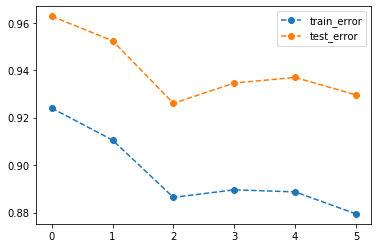

In [26]:
train_rmse = ast.literal_eval(pd.read_csv('param_simple_5.csv')['train_rmse'][0])
test_rmse = ast.literal_eval(pd.read_csv('param_simple_5.csv')['test_rmse'][0])
print('After 6 epoch rmse is: train_rmse = {} and test_rmse = {}'.format(train_rmse[-1], test_rmse[-1]))
plt.plot(train_rmse,'--o',label="train_error")
plt.plot(test_rmse,'--o',label="test_error")
plt.legend()
plt.show()

In [94]:
df_test = pd.read_csv('./movielens-fds/test.csv')
df_test.head()

,Unnamed: 0,user_id,movie_id,title,genre
0,0,1762,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
1,1,1762,67534,Big Stan (2007),Comedy
2,2,1762,2317,"Alarmist, The (a.k.a. Life During Wartime) (1997)",Comedy
3,3,1762,94011,"Big Bang, The (2011)",Action|Thriller
4,4,1762,164725,The Cheetah Girls 2 (2006),Children|Comedy|Drama


In [87]:
def submit_no_implicit(predict_f, data_test, users_index, movies_index, mean_rating, dummie_idx_users, dummie_idx_movies, N_dummies):
    
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = []
    
    for u,i in ids_to_estimate:
        if u not in users_index and i in movies_index:
            estimated.append(3)
        
        if u in users_index and i in movies_index:
            x = get_x(u,i,dummie_idx_users,dummie_idx_movies,N_dummies)
            estimated.append(predict_f(x))
            
        if i not in movies_index:
            estimated.append(mean_rating) # this is a new movie

    data_test['estimated'] = estimated
    submission = df_test.sort_values(by='estimated',ascending=False)[['user_id','movie_id']].to_csv('baseline_submision.csv',index=None)
    
    return submission

In [ ]:
submission = submit_no_implicit(reco.predict, df_test, reco.users_index, reco.movies_index, reco.mean_rating, reco.dummie_idx_users, reco.dummie_idx_movies, reco.N_dummies)

I tried the to add implicit features, for instance the "genre". In order to do that I will stack at the bottom of the vector $x$ a one-hot-encode of the genre associated to each movie.

In [27]:
dummie_genre = reco.df_train['genre'].str.get_dummies(sep="|")
dummie_genre = pd.concat([dummie_genre, reco.df_train['movie_id']],axis=1).drop_duplicates().drop(['(no genres listed)'], axis=1)
dummie_genre.head()


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_id
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,307
305,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,481
540,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1091
742,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1257
957,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1449


This is the dictionary that maps each movie to the positions of the entries in the last part of vector $x$ associated with the movie genre of the observation 

In [28]:
idx2genre = dict(zip(dummie_genre.columns[:-1], range(len(dummie_genre.columns[:-1]))))
movie2genre = {}

for i in range(len(dummie_genre)):
    movie2genre[dummie_genre.iloc[i,-1]] = np.array(dummie_genre.iloc[i,:-1]).nonzero()[0]


Then we add the year of the movie.

In [ ]:
import re

df_train['Movie_Year'] = [re.findall(r'\d{4}',s) for s in df_train.title]
df_train['Movie_Year'] = [s[-1] if len(s)>0 else 'No_Year' for s in df_train['Movie_Year']]   
df_year = df_train[['movie_id','Movie_Year']].drop_duplicates()


In [30]:
dummie_years = pd.get_dummies(df_year)

idx2year = dict(zip(df_year.movie_id, df_year.Movie_Year))
movie2year = {}

for i in range(len(df_year)):
    movie2year[dummie_years.iloc[i,0]] = np.array(dummie_years.iloc[i,1:]).nonzero()[0][0]
        

We have to update the get_x and evaluate function, taking into account the new features

In [58]:
def get_x2(user_id, movie_id, dummie_idx_users, dummie_idx_movies, dummie_idx_genre, dummie_idx_year, N_dummies):
    hot_user = dummie_idx_users[user_id] ; hot_movie = dummie_idx_movies[movie_id]
    row = np.zeros(3+len(dummie_idx_genre[movie_id]))
    col = np.r_[np.array([hot_user,hot_movie]),dummie_idx_genre[movie_id], dummie_idx_year[movie_id]] 
    data = np.ones(3+len(dummie_idx_genre[movie_id])) 
    x = csr_matrix((data, (row, col)), shape=(1, N_dummies))
    return x

def evaluate3(predict_f, data_test, users_index, 
              movies_index, mean_rating, dummie_idx_users, 
              dummie_idx_movies, N_dummies, dummie_idx_genre, dummie_idx_year):
    
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    estimated = []
    
    for u,i in ids_to_estimate:
        if u not in users_index and i in movies_index:
            estimated.append(3)
        
        if u in users_index and i in movies_index:
            x = get_x2(u,i,dummie_idx_users,dummie_idx_movies,dummie_idx_genre,dummie_idx_year,N_dummies)
            estimated.append(predict_f(x))
            
        if i not in movies_index:
            estimated.append(mean_rating) # this is a new movie

    real = data_test.rating.values
    return compute_rmse(estimated, real)

In [81]:
class RecSys_fm2():
    """ Collaborative filtering using a custom sim(u,u'). """

    def __init__(self, df_train, df_val, idx2genre=idx2genre, movie2genre=movie2genre, movie2year=movie2year, num_components=5):
        """ Constructor """
        self.df_train       = df_train
        self.df_val         = df_val
        self.num_components = num_components
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        self.N_samples = len(self.df_train)
        self.users_index  = set(self.df_train.user_id)
        self.movies_index = set(self.df_train.movie_id)
        self.N_users      = len(self.users_index) 
        self.N_movies     = len(self.movies_index)
        self.N_genre      = len(idx2genre)
        self.dummie_idx_users  = dict(zip(self.users_index, range(self.N_users)))
        self.dummie_idx_movies = dict(zip(self.movies_index, range(self.N_users,self.N_users+self.N_movies)))
        self.dummie_idx_genre  = dict(zip(movie2genre.keys(), [movie2genre[i] + self.N_users + self.N_movies for i in movie2genre.keys()]))
        self.dummie_idx_year   = dict(zip(movie2year.keys(), [movie2year[i] + self.N_users + self.N_movies + self.N_genre for i in movie2year.keys()]))
        self.N_years      = len(set(self.dummie_idx_year.values()))
        self.N_dummies    = self.N_users + self.N_movies + self.N_genre + self.N_years 

    def __sdg__(self):
        l = []
        for idx in self.training_indices:
            l.append(idx)
            if len(l)%10000 == 0: print('Wait {} idxs'.format(len(self.training_indices)-len(l)))
            y     = np.array(self.df_train.iloc[idx,3]) 
            user  = self.df_train.iloc[idx,:].user_id
            movie = self.df_train.iloc[idx,:].movie_id
            x     = get_x2(user, movie, self.dummie_idx_users, self.dummie_idx_movies, self.dummie_idx_genre, self.dummie_idx_year,self.N_dummies)
            
            prediction = self.predict(x)
            loss_derivative = 2*(prediction-y)
            #Update w0
            grad_w0 = loss_derivative
            self.w0 = self.w0 - self.learn_rate * (grad_w0 + 2*self.lmbda * self.w0)

            for i in x.indices:
                grad_w = loss_derivative * x[0,i]
                self.w[i] = self.w[i] - self.learn_rate*(grad_w + 2*self.lmbda*self.w[i])

                for f in range(self.num_components):
                    grad_V = loss_derivative*x[0,i]*(sum(x*self.V[:, f]) - x[0,i]*self.V[i, f])
                    self.V[i, f] = self.V[i, f] - self.learn_rate * (grad_V + 2*self.lmbda*self.V[i, f])
            
    def fit(self,n_epochs = 5,learning_rate =0.01,lmbda=0.07,verbose =True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.verbose = verbose
        self.learn_rate = learning_rate
        self.lmbda = lmbda
        
        self.mean_rating = self.df_train.rating.mean() 
        self.train_rmse =[]
        self.test_rmse = []
        
        # initialize model parameters
        self.w0 = self.mean_rating
        self.w  = np.random.normal(scale=1./self.N_dummies, size=self.N_dummies)
        self.V  = np.random.normal(scale=1./self.num_components, size=(self.N_dummies, self.num_components))
        
        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.N_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate3(self.predict,self.df_train, self.users_index, self.movies_index, self.mean_rating, self.dummie_idx_users, self.dummie_idx_movies,self.N_dummies, self.dummie_idx_genre,self.dummie_idx_year))
            self.test_rmse.append(evaluate3(self.predict,self.df_val, self.users_index, self.movies_index, self.mean_rating, self.dummie_idx_users, self.dummie_idx_movies,self.N_dummies, self.dummie_idx_genre,self.dummie_idx_year))
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
            
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse,'--o',label="train_error")
        plt.plot(self.test_rmse,'--o',label="test_error")
        plt.legend()
        plt.show()
        
    def predict(self, x):
        """ Single user and item prediction."""
        sx = 0 ; dx = 0 ; linear = 0
        
        for i in x.indices:
            sx += self.V[i,:]*x[0,i]
            dx += (self.V[i,:]**2)*x[0,i]**2
            linear += self.w[i]*x[0,i]
    
        interact  = sum(sx**2 - dx)/2 

        return self.w0 + linear + interact

In [82]:
recog = RecSys_fm2(df_train,df_val,num_components=10)
#recog.fit()

For the sake of clarity: the vector $x$ has his first N_users components used to map users, the following N_movies components, used to map movies and the last N_genre and N_year components, used to map movie genre and movi year.

For example, observation 595384, is converted to this vector:

In [83]:
df_train.loc[595384,:]


Unnamed: 0                  630570
user_id                        999
movie_id                      5377
rating                           2
title           About a Boy (2002)
genre         Comedy|Drama|Romance
Movie_Year                    2002
Name: 595384, dtype: object

In [84]:
x = get_x3(999, 5377, recog.dummie_idx_users, recog.dummie_idx_movies, recog.dummie_idx_genre, recog.dummie_idx_year, recog.N_dummies)
print('x is has dimension {}. The positions of this sample are {}.'.format(x.shape[1], x.indices))

x is has dimension 31242. The positions of this sample are [  953 14949 31105 31108 31115 31224].


Here we train it on a reduced dataframe to show it works properly

In [85]:
df_train_red = df_train[df_train.user_id < 100] 
df_val_red = df_val[df_val.user_id < 100]


Epoch: 0
	Train rmse: 1.0130016934644146
	Test rmse: 1.0187254677163156
Epoch: 1
	Train rmse: 0.9609675140879878
	Test rmse: 1.005993777384003
Epoch: 2
	Train rmse: 0.9219908442869984
	Test rmse: 1.000283053089043
Epoch: 3
	Train rmse: 0.8756390122192571
	Test rmse: 0.9633930038247178
Epoch: 4
	Train rmse: 0.8639196285392686
	Test rmse: 1.0020590511062863


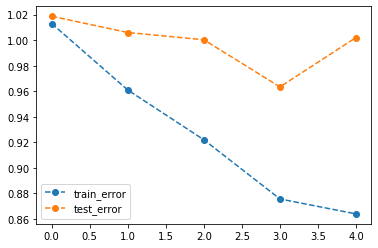

In [86]:
reco_sample = RecSys_fm2(df_train_red,df_val_red,num_components=5)
reco_sample.fit()